
### VQE custom implementation


In [ ]:
from math import pi
from typing import Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram

from src.ising import Ising
from src.vqe import create_circ, qc_eval, obj_func

In [ ]:
# Use Aer's qasm_simulator
simulator_method = 'automatic'
simulator = AerSimulator()
# define circuit params 
num_qubits = 4
circ_depth = 1
# number circuit evaluations
shots = 64
num_param = num_qubits * (circ_depth + 1)

# define initial point
rng = np.random.default_rng(seed=42)
thetas0 = rng.random(num_param) * pi #np.zeros((circ_depth + 1, num_param // (circ_depth + 1)))
# define specific optimizer
method = 'COBYLA'
# set maximum optimizer steps
maxiter = 10
# alpha-th quantile to evaluate the loss
alpha = 25

In [ ]:
# define a ferro ising model
# with uniform external field
J=1
h=0.05*J

# hamiltonian is defined with +
# following http://spinglass.uni-bonn.de/ notation 
adja_dict = {}
field = np.zeros(num_qubits)
ext_field = h
for i in range(num_qubits):
    field[i] = ext_field
    if i == num_qubits - 1:
        continue
    adja_dict[(i, i+1)] = -J
# class devoted to set the couplings and get the energy 
ising = IsingModel(num_qubits, dim=1, adja_dict=adja_dict, ext_field=field)
print(ising.AdjaDict, ising.ExtField)

In [ ]:
qc = create_circ(thetas0, num_qubits, circ_depth)
# Draw the circuit
qc.draw()

In [ ]:
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

In [ ]:
# test objective function
loss0 = obj_func(thetas0, simulator, num_qubits, circ_depth, shots, ising, alpha=alpha, verbose=True)
print(f"\nLoss at step 0 -> {loss0}")

In [ ]:
res = minimize(obj_func, thetas0, args=(simulator, num_qubits, circ_depth, shots, ising, alpha, True), 
               method=method, options={'maxiter': maxiter, 'disp':True})

In [ ]:
thetas_opt  = res.x
qc = create_circ(thetas_opt, num_qubits, circ_depth)
counts = qc_eval(qc, simulator, shots)
plot_histogram(counts)

ridefinire time to solution
in lidar loro trovano l'ottimo per ogni N numero di istanze parallele
carleo non-stoquastic QA con troyer

Noi geralizziamo facendo una funzione in 2D oppure numero di shots come parametro t in modo fa fare una famiglia di funzioni

Cosa vogliamo: resolurce to solution, moltiplico N_shot e N_step
ferromagnetico bias
mi servono alcuni for
- random su theta
- scalo su shots 
- scalo su step (maxiter)

alpha suggerito da loro (0.25)

valuto con RTS (TTS dove moltiplico per gli shots) non normalizzato per n_max

n.b. green quantum computing paper montangero

In [19]:
import numpy as np
from scipy.optimize import curve_fit
from math import ceil
from json import JSONEncoder
from matplotlib import pyplot as plt
from src.utils import collect_results, NumpyArrayEncoder

In [20]:
qubits = np.arange(4, 22, 2, dtype=int)
circ_depth = 2

psucc, ts, shots, nfevs = collect_results(qubits, circ_depth)

directory: results/N4/p2/
directory: results/N6/p2/
directory: results/N8/p2/
directory: results/N10/p2/
directory: results/N12/p2/
directory: results/N14/p2/
directory: results/N16/p2/
directory: results/N18/p2/
directory: results/N20/p2/


No zeros in succes probability for N=4
No zeros in succes probability for N=6
No zeros in succes probability for N=8
No zeros in succes probability for N=10
No zeros in succes probability for N=12
N=14, t=56, shots=8, nfev=28
N=16, t=160, shots=32, nfev=22
N=18, t=448, shots=64, nfev=30
N=20, t=1792, shots=1024, nfev=30


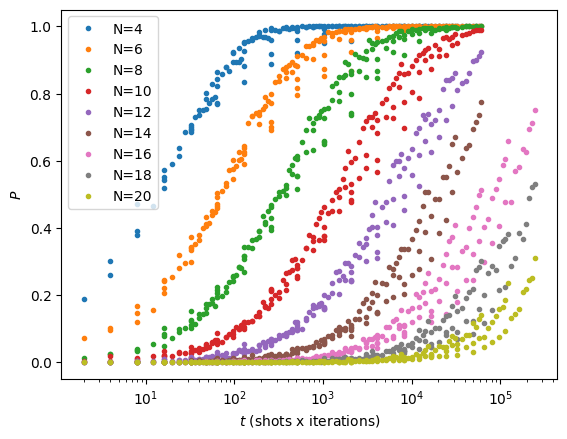

In [21]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    try:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, t={np.asarray(t)[np.asarray(p)==0.].max()}, shots={np.asarray(shots[i])[np.asarray(p)==0.].max()}, nfev={np.asarray(nfevs[i])[np.asarray(p)==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    plt.plot(p_t[0], p_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    #plt.savefig("p_t_n4-18.png")

In [22]:
def running_mean(x, n):
    cumsum = np.cumsum(np.pad(x, int(ceil(n/2)), mode='reflect')) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

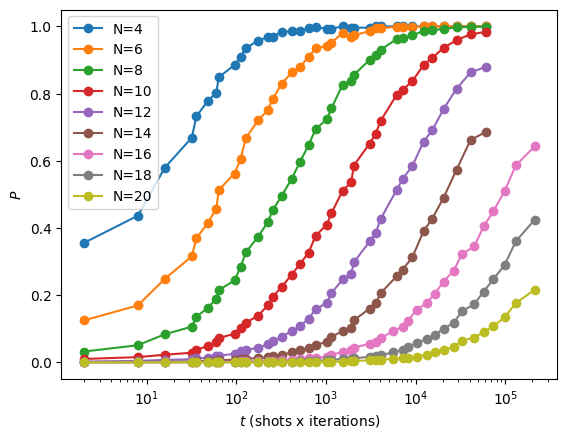

In [23]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    len_window = 12
    #p_t[1] = np.convolve(p_t[1], np.ones(len_window) / len_window, mode='same')
    p_t[1] = running_mean(p_t[1], len_window)
    plt.plot(p_t[0][::5], p_t[1][::5], "o-", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    plt.savefig("p_t_n4-18.png")

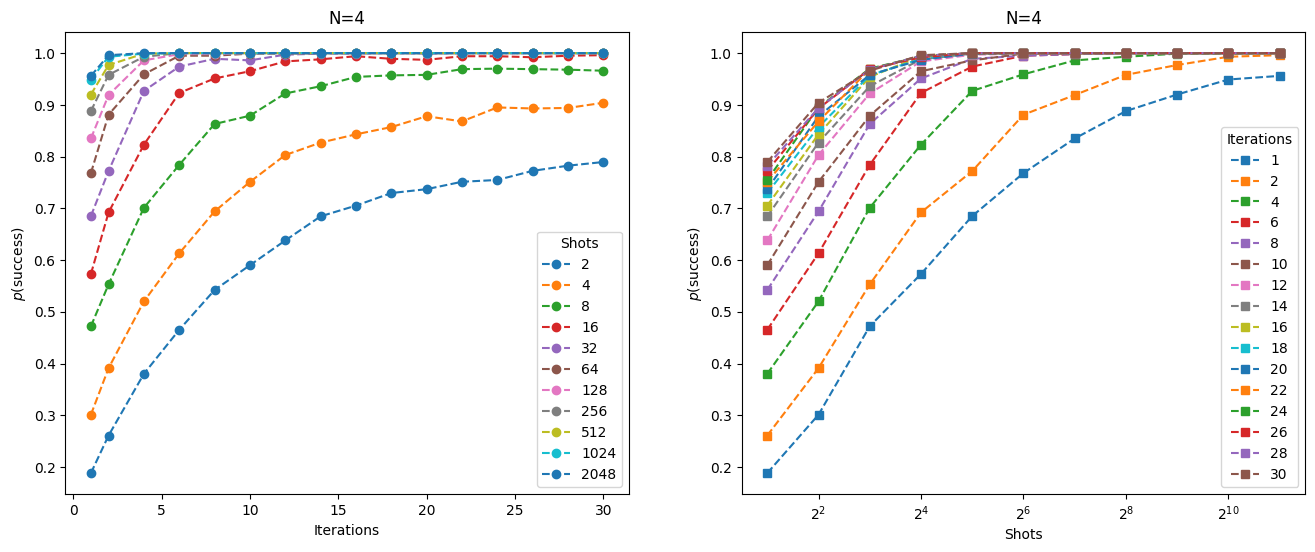

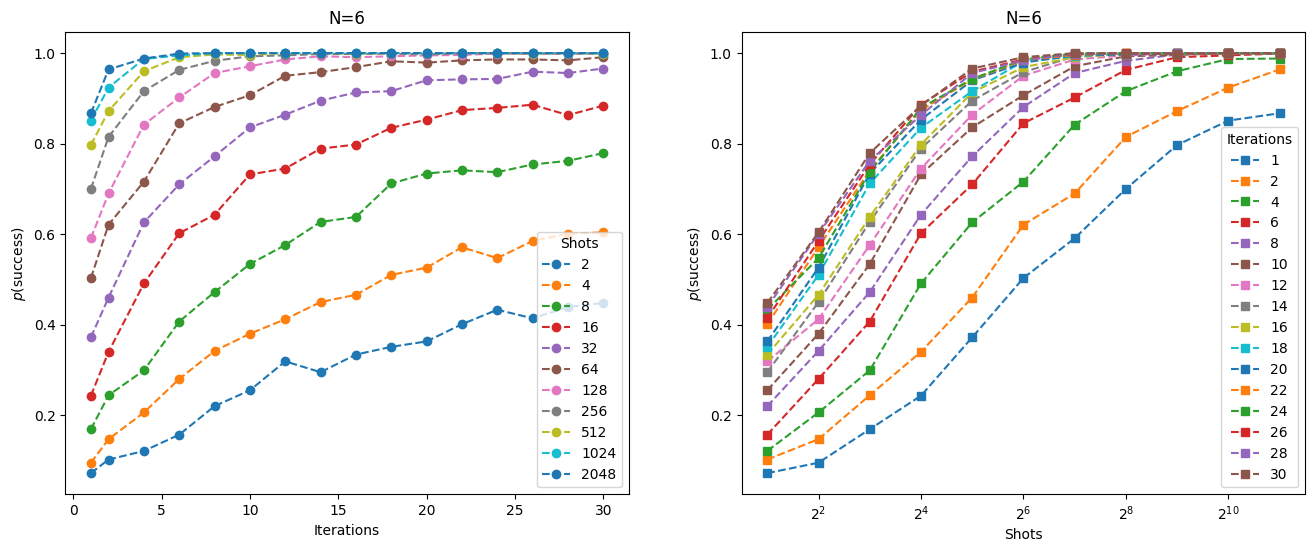

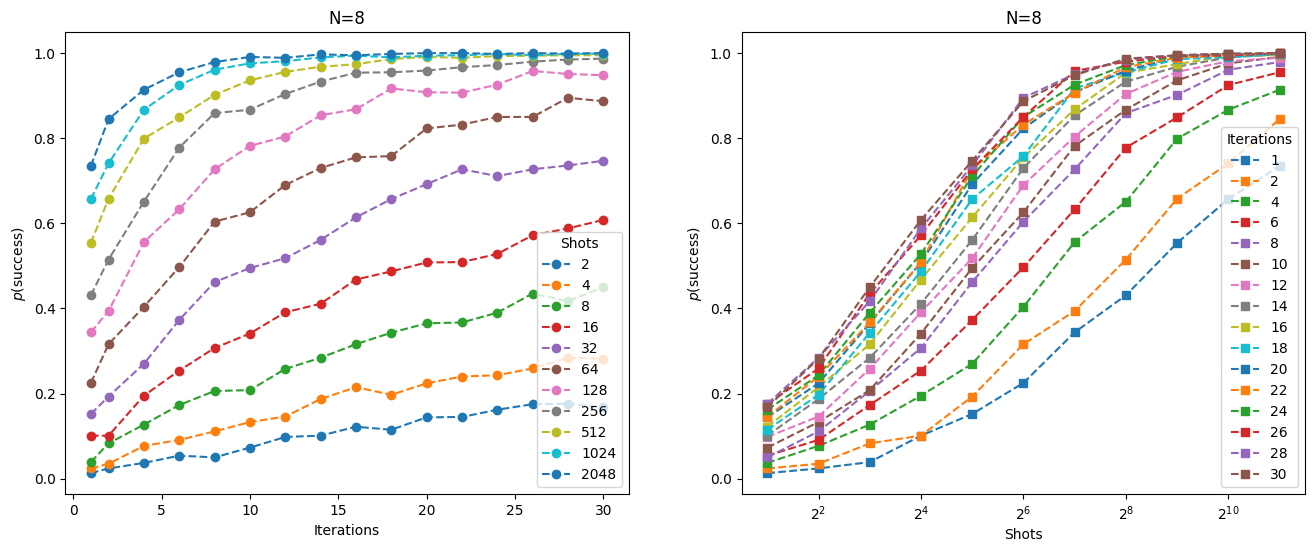

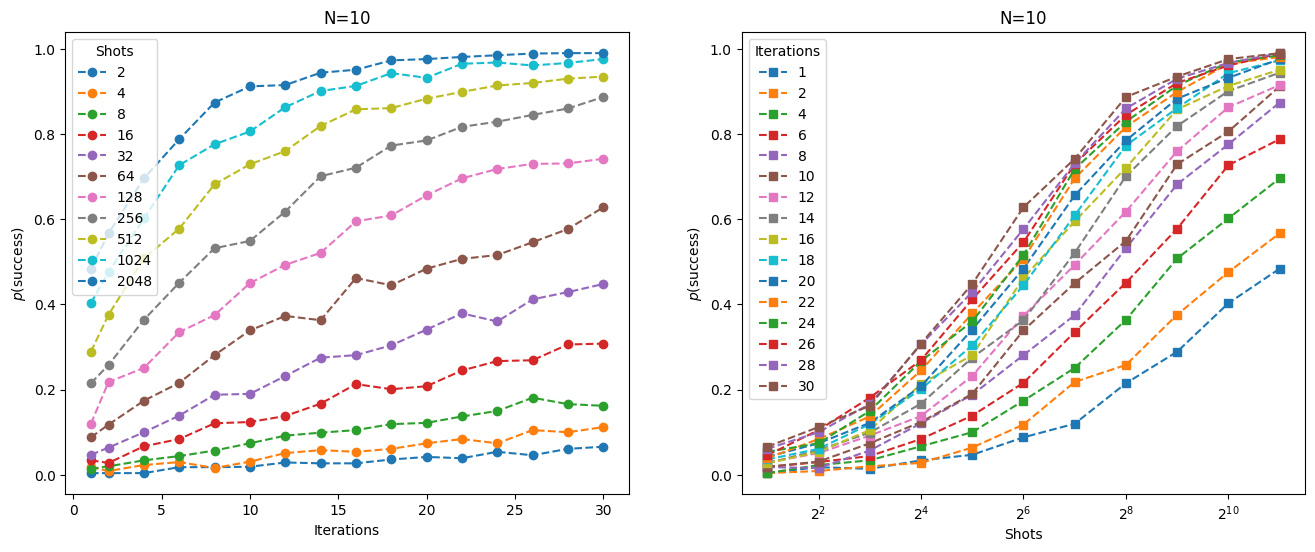

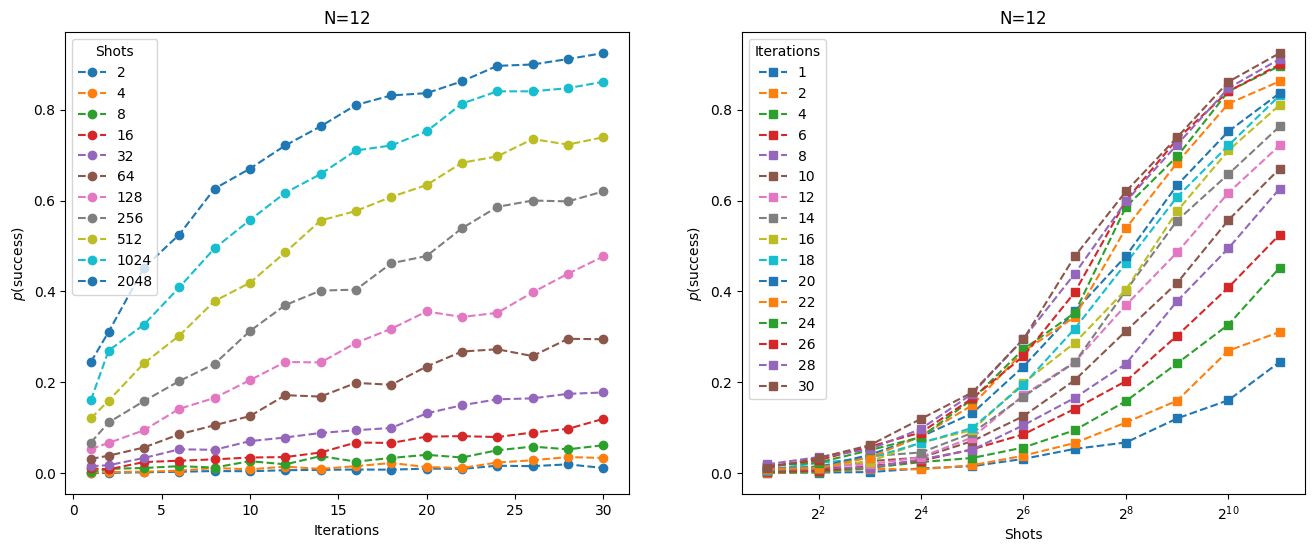

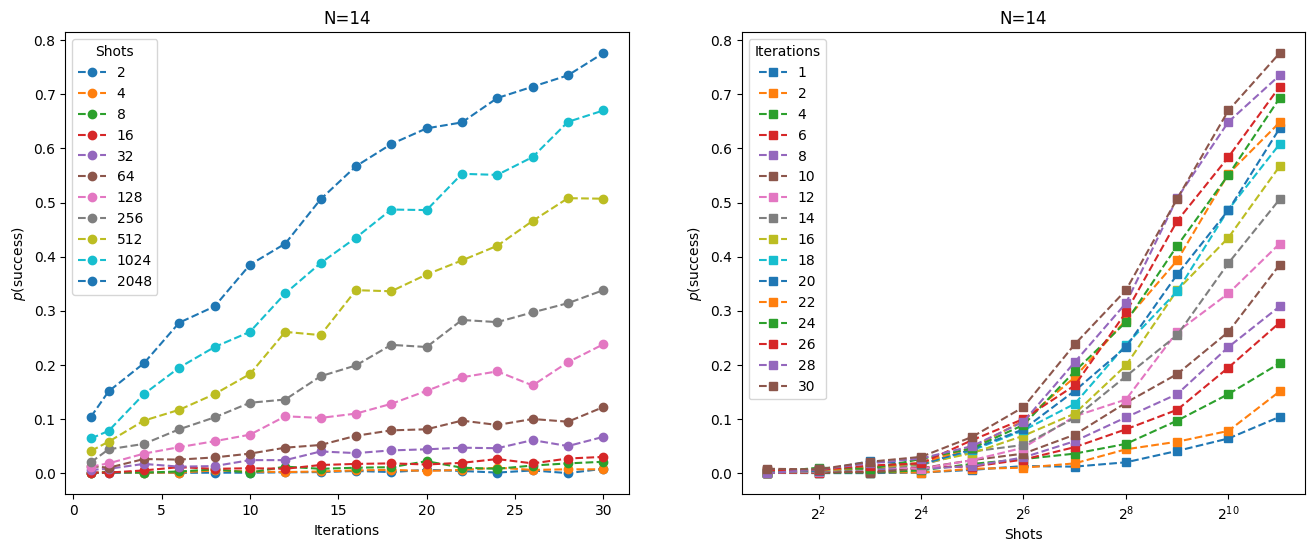

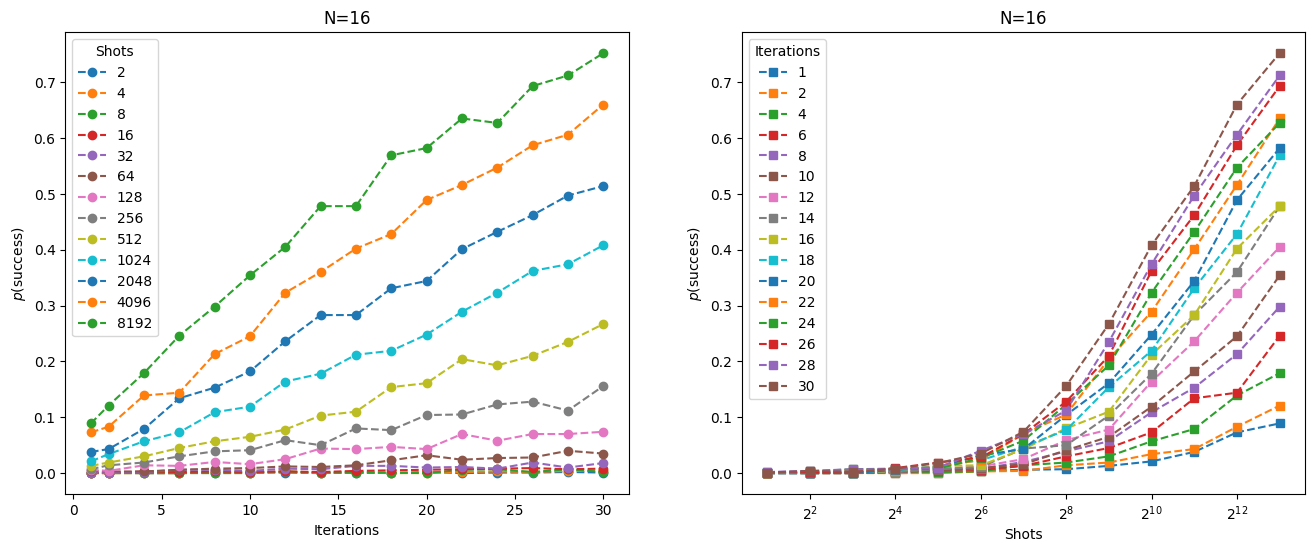

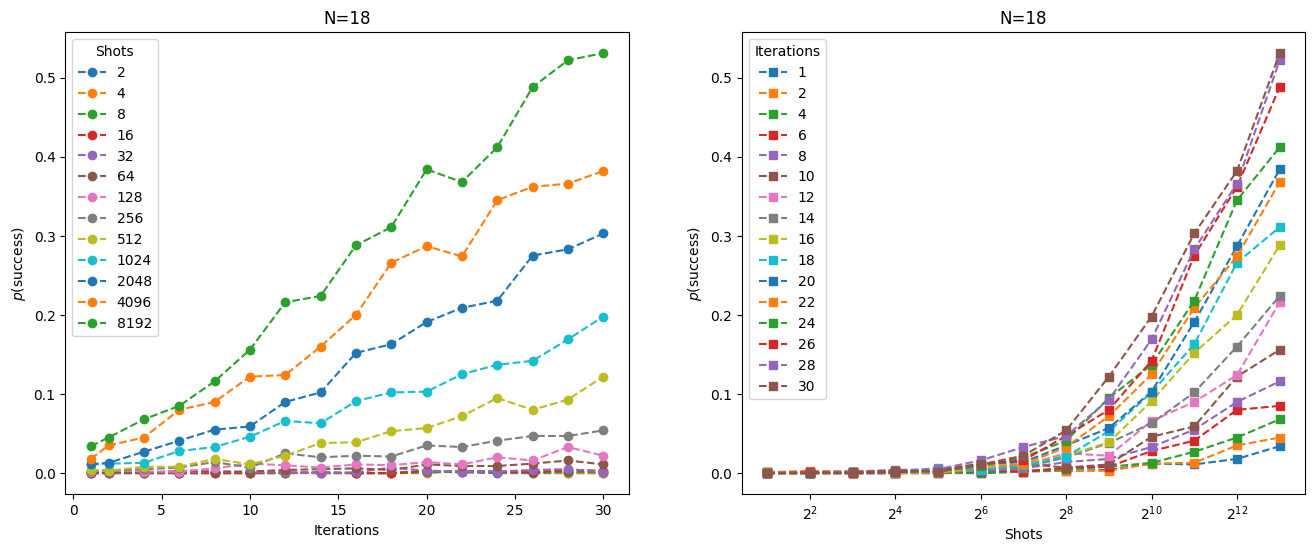

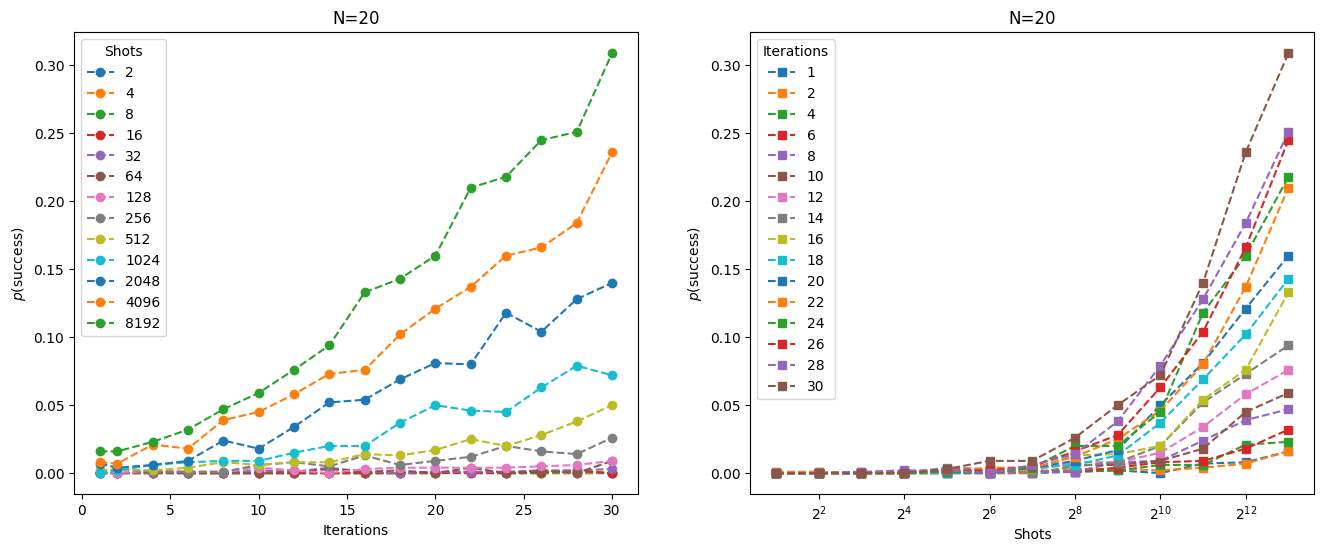

In [24]:
for k, (p,s,nfev) in enumerate(zip(psucc, shots, nfevs)):
    len_iter = np.max(nfev)//2+1

    p = np.reshape(p, (-1,len_iter))
    s = np.reshape(s, (-1,len_iter))
    nfev = np.reshape(nfev, (-1,len_iter))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    for i in range(p.shape[0]):
        ax1.plot(nfev[i,:], p[i,:], '--o', label=s[i,0])
    for j in range(p.shape[1]):
        ax2.plot(s[:,j], p[:,j], '--s', label=nfev[0,j])

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(r'$p$(success)')
    #ax1.set_ylim(0,1.1)

    ax2.set_xlabel('Shots')
    ax2.set_xscale('log', base=2)
    ax2.set_ylabel(r'$p$(success)')
    #ax2.set_ylim(0,1.1)

    ax1.legend(title='Shots')
    ax2.legend(title='Iterations')

    ax1.set_title(f'N={4+k*2}')
    ax2.set_title(f'N={4+k*2}')

    #plt.savefig(f'shots_iter_N{4+k*2}.png')

In [25]:
def compute_r(p, p_d=0.99):
    rt = np.log(1-p_d)
    rt /= np.log(1-p)
    return rt

tts_list = []
for p,t in zip(psucc, ts):
    p = np.asarray(p)
    t = np.asarray(t)
    #print(p[:20],t.shape)
    mask =  p == 0.
    mask += p == 1. # mask += p == 1.
    #p[mask] = 0.00005
    p = np.delete(p, mask)
    t = np.delete(t, mask)

    rt = compute_r(p)
    tts_list.append(t*rt)

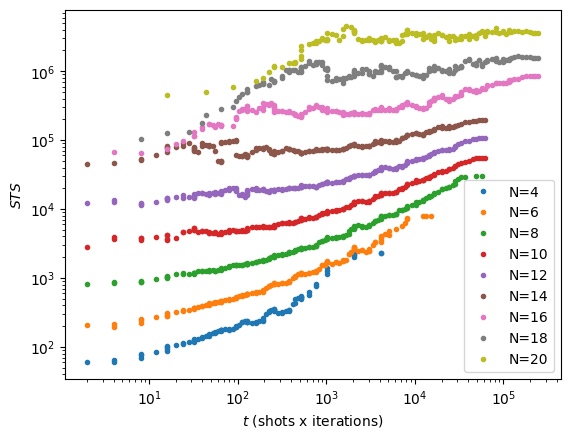

In [26]:
for i, (tts,t) in enumerate(zip(tts_list, ts)):
    if 4+i*2 > 18:
        pass#continue
    t = np.asarray(t)
    mask = np.asarray(psucc[i]) == 0.
    mask += np.asarray(psucc[i]) == 1. # mask += np.asarray(psucc[i]) == 1.
    t = np.delete(t, mask)

    tts_t = np.vstack((t, tts))
    tts_t = tts_t[:, np.argsort(tts_t[0, :])]
    # roll-mean
    len_window = 8
    tts_t[1] = running_mean(tts_t[1], len_window)
    plt.plot(tts_t[0], tts_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(1.5,50000)
    #plt.ylim(10000, 500000)
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$STS$")
    plt.legend()
    plt.savefig("STS-t_roll8.png")

In [29]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

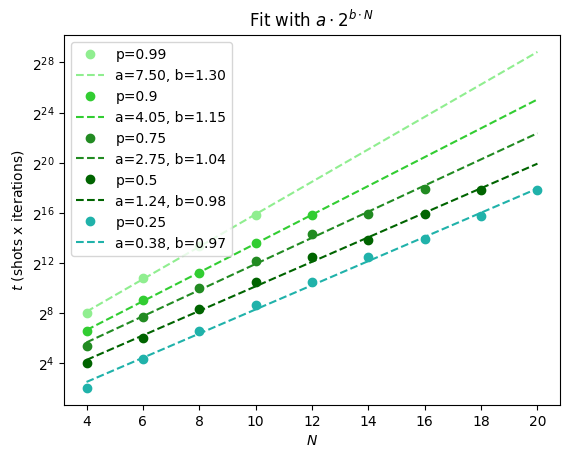

In [54]:
pt_all = []
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
min_psucc_lst = [0.99, 0.9, 0.75, 0.5, 0.25]
min_qubits = 4 
max_qubits = 20 
for min_psucc, color in zip(min_psucc_lst, colors):
    step_size = []
    for i, pt in enumerate(pt_all):
        mask = pt[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size.append(pt[0][mask][0])

    x_axes = 4 + 2*np.arange(len(step_size))

    popt, _ = curve_fit(fun_lin, x_axes, np.log2(step_size))
    plt.plot(x_axes, step_size, "o", label=f"p={min_psucc}", color=color)
    plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "--", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)

plt.yscale('log', base=2)
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")

plt.legend(loc="best")
plt.title(r"Fit with $a \cdot 2^{b \cdot N}$")

plt.savefig("t_succ.png")


## Simulation with $p=2$



In [25]:
qubits = np.arange(4, 22, 2, dtype=int)

psucc_1, ts_1, shots_1, nfevs_1 = collect_results(qubits, 1)
psucc_2, ts_2, shots_2, nfevs_2 = collect_results(qubits, 2)

directory: results/N4/p1/
directory: results/N6/p1/
directory: results/N8/p1/
directory: results/N10/p1/
directory: results/N12/p1/
directory: results/N14/p1/
directory: results/N16/p1/
directory: results/N18/p1/
directory: results/N20/p1/
directory: results/N4/p2/
directory: results/N6/p2/
directory: results/N8/p2/
directory: results/N10/p2/
directory: results/N12/p2/
directory: results/N14/p2/
directory: results/N16/p2/
directory: results/N18/p2/
directory: results/N20/p2/


No zeros in succes probability for N=4
No zeros in succes probability for N=4
No zeros in succes probability for N=6
No zeros in succes probability for N=6
No zeros in succes probability for N=8
No zeros in succes probability for N=8
No zeros in succes probability for N=10
No zeros in succes probability for N=10
No zeros in succes probability for N=12
N=12, p=2, t=16, shots=2, nfev=8
No zeros in succes probability for N=14
N=14, p=2, t=56, shots=8, nfev=28
N=16, p=1, t=8, shots=2, nfev=4
N=16, p=2, t=160, shots=32, nfev=22
N=18, p=1, t=768, shots=128, nfev=30
N=18, p=2, t=448, shots=64, nfev=30


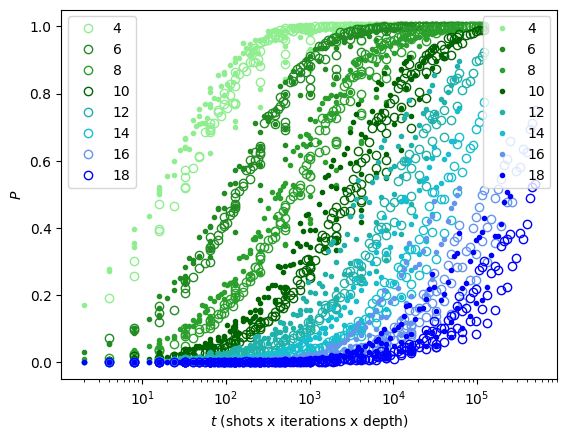

In [55]:
colors = ['lightgreen','forestgreen','tab:green','darkgreen', 'lightseagreen', 'tab:cyan','cornflowerblue' , 'blue', 'navy']
plots1 = []
plots2 = []

for i, (p,t) in enumerate(zip(psucc_1, ts_1)):
    if 4+i*2 > 18:
        continue
    try:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, p=1, t={np.asarray(t)[np.asarray(p)==0.].max()}, shots={np.asarray(shots_1[i])[np.asarray(p)==0.].max()}, nfev={np.asarray(nfevs_1[i])[np.asarray(p)==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    # plot for each dimension
    p_t_1 = np.vstack((t, p))
    p_t_1 = p_t_1[:, np.argsort(p_t_1[0, :])]
    plot1, = plt.plot(p_t_1[0], p_t_1[1], ".", label=f"{4+i*2}", color=colors[i])
    plots1.append(plot1)

    try:
        last_zero = np.argwhere(np.isclose(psucc_2[i], 0.))
        print(f"N={4+i*2}, p=2, t={np.asarray(ts_2[i])[np.asarray(psucc_2[i])==0.].max()}, shots={np.asarray(shots_2[i])[np.asarray(psucc_2[i])==0.].max()}, nfev={np.asarray(nfevs_2[i])[np.asarray(psucc_2[i])==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    p_t_2 = np.vstack((ts_2[i], psucc_2[i]))
    p_t_2 = p_t_2[:, np.argsort(p_t_2[0, :])]
    plot2, = plt.plot(p_t_2[0]*2, p_t_2[1], "o", label=f"{4+i*2}", color=colors[i], fillstyle='none')
    plots2.append(plot2)

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations x depth)")
    plt.ylabel(r"$P$")

# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='upper right')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left')

    #plt.savefig("p_t_n4-18.png")

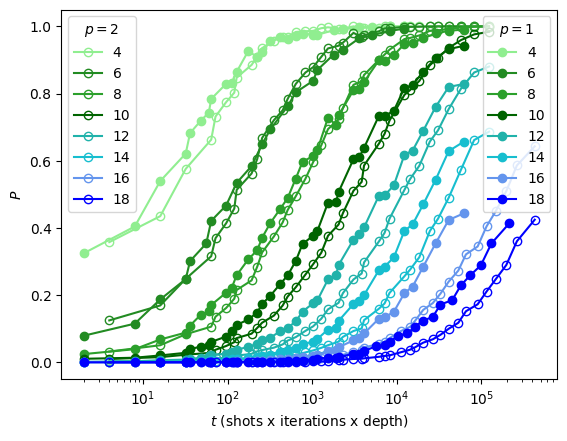

In [54]:
colors = ['lightgreen','forestgreen','tab:green','darkgreen', 'lightseagreen', 'tab:cyan','cornflowerblue' , 'blue', 'navy']
plots1 = []
plots2 = []

for i, (p,t) in enumerate(zip(psucc_1, ts_1)):
    if 4+i*2 > 18:
        continue
    p_t1 = np.vstack((t, p))
    p_t1 = p_t1[:, np.argsort(p_t1[0, :])]
    len_window = 12
    #p_t1[1] = np.convolve(p_t1[1], np.ones(len_window) / len_window, mode='same')
    p_t1[1] = running_mean(p_t1[1], len_window)
    plot1, = plt.plot(p_t1[0][::5], p_t1[1][::5], "o-", label=f"{4+i*2}", color=colors[i])
    plots1.append(plot1)

    p_t2 = np.vstack((ts_2[i], psucc_2[i]))
    p_t2 = p_t2[:, np.argsort(p_t2[0, :])]
    p_t2[1] = running_mean(p_t2[1], len_window)
    plot2, = plt.plot(p_t2[0][::5]*2, p_t2[1][::5], "o-", label=f"{4+i*2}", fillstyle='none', color=colors[i])
    plots2.append(plot2)

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations x depth)")
    plt.ylabel(r"$P$")

# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='upper right', title=r'$p=1$')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left', title=r'$p=2$')

In [71]:
def compute_r(p, p_d=0.99):
    rt = np.log(1-p_d)
    rt /= np.log(1-p)
    return rt

tts_list = []
for p,t in zip(psucc_2, ts_2):
    p = np.asarray(p)
    t = np.asarray(t)
    print(p[50:60], t[50:60])
    mask =  p == 0.
    mask += p == 1. # mask += p == 1.
    #p[mask] = 0.00005
    p = np.delete(p, mask)
    t = np.delete(t, mask)

    rt = compute_r(p)
    tts_list.append(t*rt)

[0.823 0.923 0.951 0.965 0.984 0.988 0.994 0.989 0.987 0.994] [ 64  96 128 160 192 224 256 288 320 352]
[0.491 0.602 0.643 0.732 0.745 0.789 0.798 0.835 0.853 0.874] [ 64  96 128 160 192 224 256 288 320 352]
[0.195 0.254 0.307 0.341 0.391 0.411 0.468 0.487 0.508 0.509] [ 64  96 128 160 192 224 256 288 320 352]
[0.067 0.084 0.121 0.124 0.138 0.167 0.213 0.201 0.208 0.245] [ 64  96 128 160 192 224 256 288 320 352]
[0.025 0.028 0.031 0.035 0.036 0.046 0.068 0.067 0.081 0.082] [ 64  96 128 160 192 224 256 288 320 352]
[0.005 0.011 0.008 0.009 0.008 0.015 0.017 0.018 0.016 0.019] [ 64  96 128 160 192 224 256 288 320 352]
[0.003 0.002 0.003 0.002 0.003 0.002 0.004 0.005 0.006 0.007] [ 64  96 128 160 192 224 256 288 320 352]
[0.001 0.    0.    0.    0.001 0.    0.    0.    0.003 0.002] [ 64  96 128 160 192 224 256 288 320 352]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 64  96 128 160 192 224 256 288 320 352]


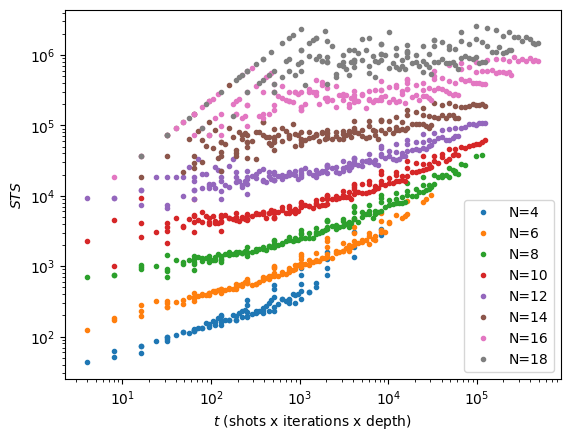

In [64]:
for i, (tts,t) in enumerate(zip(tts_list, ts_2)):
    if 4+i*2 > 18:
        continue
    t = np.asarray(t)
    mask = np.asarray(psucc_2[i]) == 0.
    mask += np.asarray(psucc_2[i]) == 1. # mask += np.asarray(psucc[i]) == 1.
    t = np.delete(t, mask)

    tts_t = np.vstack((t, tts))
    tts_t = tts_t[:, np.argsort(tts_t[0, :])]
    # roll-mean
    #len_window = 8
    #tts_t[1] = running_mean(tts_t[1], len_window)
    plt.plot(tts_t[0]*2, tts_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(1.5,50000)
    #plt.ylim(10000, 500000)
    plt.xlabel(r"$t$ (shots x iterations x depth)")
    plt.ylabel(r"$STS$")
    plt.legend()


#TODO

- [ ] nel plot dello scaling esponenziale della prob di successo inserire anche altre famiglie di p, i. e., p=[0.5, 0.6, 0.7, 0.8, 0.9]
- [ ] studiare i rumri mediani degli ultimi device di IBM e capire quali sono i valori, a quel punto inserire il rumore nel codice o con una classe prefissata capendo come estrarre i valori del rumore oppure settandoli a mano
- [ ] verificare la differenza tra i risultati del circuito rumoroso e quello del simulatore esatto per una taglia ragionevole e stampare i risultati per Guglielmo
- [ ] $p=2$ servono 10k per alcuni circuiti, da 14 in poi. VALUTARE BENE!!
- [x] d'ora in poi i tempi della cpu vanno normalizzati per numero di cpu e mediati per le iterazioni, l'obiettivo è avere un t/CPU medio
- [ ] provare modello frustrato +- 1



## Test circuits

Implement RealAmplitude ansatz and look for reliable noise setting.

In [1]:
from src.utils import param_circ

num_qubits = 4
num_layer = 2

circ = param_circ(num_qubits, num_layer)

print(circ)
#circ.num_parameters / circ.num_qubits - 1

        ┌──────────────┐ ░                      ░ ┌──────────────┐ ░           »
   q_0: ┤ Ry(theta[0]) ├─░───■──────────────■───░─┤ Ry(theta[4]) ├─░───■───────»
        ├──────────────┤ ░ ┌─┴─┐            │   ░ ├──────────────┤ ░ ┌─┴─┐     »
   q_1: ┤ Ry(theta[1]) ├─░─┤ X ├──■─────────┼───░─┤ Ry(theta[5]) ├─░─┤ X ├──■──»
        ├──────────────┤ ░ └───┘┌─┴─┐       │   ░ ├──────────────┤ ░ └───┘┌─┴─┐»
   q_2: ┤ Ry(theta[2]) ├─░──────┤ X ├──■────┼───░─┤ Ry(theta[6]) ├─░──────┤ X ├»
        ├──────────────┤ ░      └───┘┌─┴─┐┌─┴─┐ ░ ├──────────────┤ ░      └───┘»
   q_3: ┤ Ry(theta[3]) ├─░───────────┤ X ├┤ X ├─░─┤ Ry(theta[7]) ├─░───────────»
        └──────────────┘ ░           └───┘└───┘ ░ └──────────────┘ ░           »
meas_0: ═══════════════════════════════════════════════════════════════════════»
                                                                               »
meas_1: ═══════════════════════════════════════════════════════════════════════»
                            

In [5]:
from qiskit.circuit.library import  RealAmplitudes

qc = RealAmplitudes(num_qubits, reps=num_layer, insert_barriers=True, entanglement='circular')
qc.measure_all()

print(qc.decompose())

        ┌──────────┐ ░ ┌───┐                ░ ┌──────────┐ ░ ┌───┐          »
   q_0: ┤ Ry(θ[0]) ├─░─┤ X ├──■─────────────░─┤ Ry(θ[4]) ├─░─┤ X ├──■───────»
        ├──────────┤ ░ └─┬─┘┌─┴─┐           ░ ├──────────┤ ░ └─┬─┘┌─┴─┐     »
   q_1: ┤ Ry(θ[1]) ├─░───┼──┤ X ├──■────────░─┤ Ry(θ[5]) ├─░───┼──┤ X ├──■──»
        ├──────────┤ ░   │  └───┘┌─┴─┐      ░ ├──────────┤ ░   │  └───┘┌─┴─┐»
   q_2: ┤ Ry(θ[2]) ├─░───┼───────┤ X ├──■───░─┤ Ry(θ[6]) ├─░───┼───────┤ X ├»
        ├──────────┤ ░   │       └───┘┌─┴─┐ ░ ├──────────┤ ░   │       └───┘»
   q_3: ┤ Ry(θ[3]) ├─░───■────────────┤ X ├─░─┤ Ry(θ[7]) ├─░───■────────────»
        └──────────┘ ░                └───┘ ░ └──────────┘ ░                »
meas_0: ════════════════════════════════════════════════════════════════════»
                                                                            »
meas_1: ════════════════════════════════════════════════════════════════════»
                                                                

In [34]:
from qiskit.providers.aer import AerSimulator

sim = AerSimulator(
            method='automatic',
            max_parallel_threads=1,
        )

In [28]:
from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer.noise import NoiseModel

device_backend = FakeVigo()
noise_model = NoiseModel.from_backend(device_backend)
#sim.set_options(noise_model=noise_model)

In [53]:
from qiskit.providers.aer import AerProvider

prov = AerProvider()
prov.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [34]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ, transpile
from qiskit.providers.aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_histogram


# get a real backend from a real provider
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-11-16 18:20:20,064: Credentials are already in use. The existing account in the session will be replaced.


In [39]:
#print(provider.backends())
backend = provider.get_backend('ibmq_lima')
noise_model = NoiseModel.from_backend(backend)

simulator = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
            noise_model = noise_model, 
        )

exact_sim = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
        )
# generate a simulator that mimics the real quantum system with the latest calibration results

qubits = 6
circ_depth = 1 
# create the circuit
# standard VQE ansatz
qc = RealAmplitudes(
    qubits,
    reps=circ_depth,
    insert_barriers=True,
    entanglement="circular",
)
# measure all qubits at the end of the circuit
qc.measure_all()
params = np.zeros(qc.num_parameters) #np.random.uniform(-2 * pi, 2 * pi, qc.num_parameters)
qc = qc.assign_parameters(params)

# Execute the circuit with fixed params
job = simulator.run(transpile(qc, simulator))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, filename='noisy_sim.png')

In [40]:
# Execute the circuit with fixed params
job = exact_sim.run(transpile(qc, exact_sim))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, filename='exact_sim.png')

In [3]:
import numpy as np

np.random.randint(0,1, 10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

TODO

- aumentare le iterazioni per migliorare la stima 
- rifare N=18
- moltiplico step e iteration ma mantengo il colore per ogni size ho un valore e quindi un plot per tutte le taglie (size scaling) salvare la migliore energia che trovo e quando la trovo.


## Solve Ising Model 

Find the ground state for custom Ising model 1D

In [8]:
import numpy as np

from src.ising import Ising
from src.utils import get_ising, create_ising1d

In [9]:
DIM = 1
qubits = 4 
seed = 42
type_ising = 'ferro'

In [10]:
# define generator for initial point
rng = np.random.default_rng(seed=seed)

J, h = get_ising(qubits, ising_type=type_ising, rng=rng)
# hamiltonian is defined with +
# following http://spinglass.uni-bonn.de/ notation
ising, global_min = create_ising1d(qubits, DIM, J, h)

In [9]:
import numpy as np
from numpy import linalg as LA
import functools
from scipy import sparse

In [7]:
def kron(gate_lst):
    return(functools.reduce(np.kron, gate_lst))


def X(i, n): 
    if i<0 or i>=n or n<1:
        raise ValueError('Bad value of i and/or n.')
    X_list = [np.array([[0,1],[1,0]]) if j==i else np.eye(2) for j in range(n)]
    return kron(X_list)


def Y(i, n):
    if i<0 or i>=n or n<1:
        raise ValueError('Bad value of i and/or n.')
    Y_list = [np.array([[0,-1j],[1j,0]]) if j==i else np.eye(2) for j in range(n)]
    return kron(Y_list)


def Z(i, n):
    if i<0 or i>=n or n<1:
        raise ValueError('Bad value of i and/or n.')
    Z_list = [np.array([[1,0],[0,-1]]) if j==i else np.eye(2) for j in range(n)]
    return kron(Z_list)


def sortES(eigVals,eigVecs): 
    '''
    Sort eigensystem.
    '''

    # Zip the associated eigenvalues and eigenvectors together and sort by eigenvalue
    eigSystem = sorted(zip(eigVals,np.transpose(eigVecs)),key=lambda x: x[0])
    eigValsOut = [eVal for (eVal,eVec) in eigSystem]
    eigVecsOut = [eVec for (eVal,eVec) in eigSystem]

    return eigValsOut,eigVecsOut

def printstate(v,L,cutoff): 
    for i in range(1<<L):
        if(v[i]*np.conj(v[i])>cutoff):
            print(i, "-", np.binary_repr(i, width=L), "-", v[i], v[i]*np.conj(v[i]))


In [50]:
%%time


L=1 
Gamma=0
Jcoupl=1
h_Q = np.zeros(L)
J_Q = np.diag(np.ones(L-1), k=1)
#J_Q[0,L-1]=1 #PBC
LambdaReg=L+1

H_z = sum([J_Q[i,j]*Z(i,L) @ Z(j,L) for i in range(L) for j in range(L)]) + sum([h_Q[i]*Z(i,L) for i in range(L)])
#H_x = sum([X(i,L) for i in range(L)])

#questo ti crea un TFIM con J_Q=1 e h local fields = 0 ma puoi cambiare


H = -Jcoupl*H_z 
if (L<5): print("Hamiltonian matrix",H)
opm=sparse.coo_matrix(H)


#eigVals,eigVecs = LA.eig(H)
eigVals, eigVecs = sparse.linalg.eigs(opm)

eigVals,eigVecs = sortES(eigVals,eigVecs)
#print("Spectrum exact")
#print(eigVals[:1<<L])
print("\nGround state energy exact")
en_exact=eigVals[0]
print(en_exact)
#print the lowest lying strings..
print("\nGround state wf exact")
psiGS = eigVecs[0]
printstate(eigVecs[0],L,0.001)


Hamiltonian matrix [[-0. -0.]
 [-0. -0.]]


/home/scriva/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


TypeError: Cannot use scipy.linalg.eig for sparse A with k >= N - 1. Use scipy.linalg.eig(A.toarray()) or reduce k.